In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, model, utils, metrics

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - Mobile Net V3 Large pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

In [2]:
show_pic = False

if show_pic:
    Image.open('../model_architecture.png')

In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
train_label.head()

file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True

### Initialize Dataset and Dataloader

In [4]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [5]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 'gender' : gender_dict, 'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, {'age_dict' : age_dict, 'race_dict' : race_dict, 'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [6]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels.head()

file  age  gender  race  age_weight  gender_weight  race_weight  \
0  train/1.jpg    6       0     3    0.000202       0.000027     0.000102   
1  train/2.jpg    4       1     2    0.000065       0.000031     0.000102   
2  train/4.jpg    3       1     2    0.000049       0.000031     0.000102   
3  train/5.jpg    3       1     2    0.000049       0.000031     0.000102   
4  train/7.jpg    5       0     6    0.000116       0.000027     0.000136   

   total_weight group  count  group_weight  
0      0.000330   603    272      0.003676  
1      0.000197   412    931      0.001074  
2      0.000181   312   1347      0.000742  
3      0.000181   312   1347      0.000742  
4      0.000279   506    961      0.001041

In [7]:
train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], axis=1)

file  age  gender  race group  count  group_weight
0          train/1.jpg    6       0     3   603    272      0.003676
1          train/2.jpg    4       1     2   412    931      0.001074
2          train/4.jpg    3       1     2   312   1347      0.000742
3          train/5.jpg    3       1     2   312   1347      0.000742
4          train/7.jpg    5       0     6   506    961      0.001041
...                ...  ...     ...   ...   ...    ...           ...
69390  train/86738.jpg    2       0     2   202    510      0.001961
69391  train/86741.jpg    2       0     2   202    510      0.001961
69392  train/86742.jpg    8       1     2   812     93      0.010753
69393  train/86743.jpg    2       1     4   214    663      0.001508
69394  train/86744.jpg    5       0     0   500   1104      0.000906

[69395 rows x 7 columns]

In [8]:
root_dir = Path('/home/FairFace_Modeling/')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 512

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


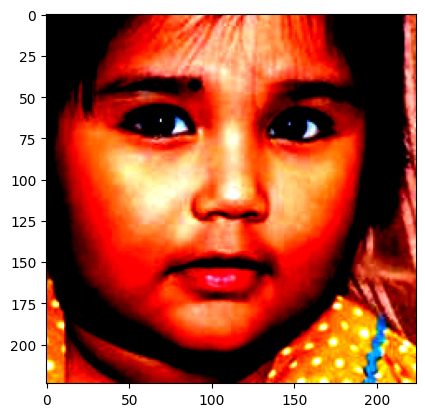

In [9]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 35)

### Sample data

In [10]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)
model = model.FairFaceMobileNet(mobilenet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


### Plug-in BYOL Pytorch

In [13]:
from byol_pytorch import BYOL

learner = BYOL(
    model,
    image_size = 224,
    hidden_layer = -2
)

### Train model

In [14]:
def train_model(model, criterion, optimizer, scheduler_lr, device, loaders, tensor_writer, mappings, class_weights, byol_learner, n_epochs=25):

    """Fine-tune the model and returns it
    Args:
        model: The model to be trained.
        criterion: The loss function to be used.
        optimizer: The optimizer to be used.
        scheduler_lr: The learning rate scheduler to be used.
        device: The device to be used.
        loaders: A dictionary containing the train and test data loaders.
        tensor_writer: A TensorBoard writer.
        mappings: A dictionary mapping labels to their corresponding indices.
        n_epochs: The number of epochs to train for.

    Returns:
        The trained model.
    """
    # unpack_loss_coefs
    age_weight: float = class_weights['age']
    gender_weight: float = class_weights['gender']
    race_weight: float = class_weights['race']
    # Whether to use learning rate scheduler
    use_lr_scheduler = False

    # Train and validation data pytorch loaders 
    train_loader, test_loader = loaders

    # In the custom implementation of the pytorch dataset train_mode attribute was added for more convenient observance of the image
    data.check_train_mode_off(train_loader, 'train')
    data.check_train_mode_off(test_loader, 'test')

    # Flag that shows whether CCE or BCE is used during training
    cce_mark = type(criterion) == torch.nn.modules.loss.CrossEntropyLoss

    # Initializing of minimal value of validation loss to compare in following code
    valid_loss_min = torch.inf

    # starts training epochs[default = 25]
    for epoch in range(1, n_epochs):
        # Define train and each ANN head losses to compare if it is decreasing during training process
        train_loss = .0
        age_train_loss, race_train_loss, gender_train_loss = .0, .0, .0

        model.train()

        # whether learning rate scheduler is used make the step of it or not
        if use_lr_scheduler:
            scheduler_lr.step()
        
        # ground truths and predictions of the each head of the ANN
        all_age_preds = []
        all_age_labels = []

        all_gender_preds = []
        all_gender_labels = []

        all_race_preds = []
        all_race_labels = []

        # As far as loaders have mini-batch feature and provide samples in that amounts, so iterate over these mini-batches 
        for sample_batched in tqdm(train_loader):
            # read every element of the sample and send it to device[GPU as it is expected]
            image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
            gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

            # get model's predictions
            output = model(image)
            # predict age, gender, race labels
            age_pred = output['age_pred'].to(device)
            gender_pred = output['gender_pred'].to(device)
            race_pred = output['race_pred'].to(device)
            
            # calculate loss[CCE or BCE]
            if cce_mark:
                age_loss = criterion(age_pred, age)
                race_loss = criterion(race_pred, race)
                gender_loss = criterion(gender_pred, gender)
            else:
                # If it is BCE firstly convert to the one-hot encoded vector
                age_dummy = data.get_dummy(age_dict, age, device)
                race_dummy = data.get_dummy(race_dict, race, device)
                gender_dummy = data.get_dummy(gender_dict, gender, device)

                # Then calculate the loss
                age_loss = criterion(age_pred, age_dummy)
                race_loss = criterion(race_pred, race_dummy)
                gender_loss = criterion(gender_pred, gender_dummy)

            # total loss and back propagation
            loss = age_loss * age_weight + race_loss * race_weight + gender_loss * gender_weight

            # add the loss of age, race, gender heads to their total losses of the epoch
            age_train_loss += age_loss
            race_train_loss += race_loss
            gender_train_loss += gender_loss
            train_loss += loss 

            # Clear the gradients of all parameters
            optimizer.zero_grad()
            # Compute the gradients of the loss function with respect to the model's parameters
            loss.backward()
            # optimization step
            optimizer.step()
            # pytorch byol learner step
            byol_learner.update_moving_average()

            # Get Age prediction 
            _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
            # Get Race prediction
            _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
            # Get Gender prediction 
            _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)

            # Append computed above predictions to the vector for the following comparing
            all_age_preds.extend([i.item() for i in age_predicted])
            all_gender_preds.extend([i.item() for i in gender_predicted])
            all_race_preds.extend([i.item() for i in race_predicted])

            # Append true labels of the dataset to the vector for the following comparing 
            all_age_labels.extend([i.item() for i in age])
            all_gender_labels.extend([i.item() for i in gender])
            all_race_labels.extend([i.item() for i in race])

        # Every epoch log metrics and losses to the tensorboard to track whether the model is training or not
        
        losses = {'loss' : train_loss, 'age' : age_train_loss, 'race' : race_train_loss, 'gender' : gender_train_loss}
        losses = {k : v / len(train_loader) for (k, v) in losses.items()}
        labels = {'age' : all_age_labels, 'race' : all_race_labels, 'gender' : all_gender_labels}
        preds = {'age' : all_age_preds, 'race' : all_race_preds, 'gender' : all_gender_preds}

        print('Training step:')
        tensor_writer = metrics.log_tensorboard(tensor_writer, losses, labels, preds, mappings, epoch, mode='Train')


        # Start evaluation step
        model.eval()

        # Don't compute gradients during this step
        with torch.no_grad():
            # Define vectors of true labels and predictions, current validation loss and each head's loss as like as above
            # for accuracy, precision, recall, f1 etc. comparing
            valid_age_preds = []
            valid_age_labels = []

            valid_gender_preds = []
            valid_gender_labels = []

            valid_race_preds = []
            valid_race_labels = []

            valid_loss = .0
            valid_age_loss, valid_race_loss, valid_gender_loss = .0, .0, .0

            # Iterate over the batches of the validation dataloader
            for sample_batched in tqdm(test_loader):
                # read every element of the sample and send it to device[GPU as it is expected]
                image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
                gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

                # get model's predictions
                output = model(image)

                # predict age, gender, race labels
                age_pred = output['age_pred'].to(device)
                gender_pred = output['gender_pred'].to(device)
                race_pred = output['race_pred'].to(device)

                # calculate loss[CCE or BCE]
                if cce_mark:
                    age_loss = criterion(age_pred, age)
                    race_loss = criterion(race_pred, race)
                    gender_loss = criterion(gender_pred, gender)
                else:
                    # If it is BCE firstly convert to the one-hot encoded vector
                    age_dummy = data.get_dummy(age_dict, age, device)
                    race_dummy = data.get_dummy(race_dict, race, device)
                    gender_dummy = data.get_dummy(gender_dict, gender, device)

                    # Then calculate the loss
                    age_loss = criterion(age_pred, age_dummy)
                    race_loss = criterion(race_pred, race_dummy)
                    gender_loss = criterion(gender_pred, gender_dummy)

                # total loss and back propagation
                loss = age_loss * age_weight + race_loss * race_weight + gender_loss * gender_weight

                # add the loss of age, race, gender heads to their total losses of the epoch
                valid_loss += loss.item()
                valid_age_loss += age_loss
                valid_race_loss += race_loss
                valid_gender_loss += gender_loss

                # Get Age prediction 
                _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
                # Get Race prediction 
                _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
                # Get Gender prediction 
                _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)

                # Append computed above predictions to the vector for the following comparing
                valid_age_preds.extend([i.item() for i in age_predicted])
                valid_gender_preds.extend([i.item() for i in gender_predicted])
                valid_race_preds.extend([i.item() for i in race_predicted])

                # Append true labels of the dataset to the vector for the following comparing 
                valid_age_labels.extend([i.item() for i in age])
                valid_gender_labels.extend([i.item() for i in gender])
                valid_race_labels.extend([i.item() for i in race])

            # Every epoch log metrics and losses to the tensorboard to track whether the model is training or not
            losses = {'loss' : valid_loss, 'age' : valid_age_loss, 'race' : valid_race_loss, 'gender' : valid_gender_loss}
            losses = {k : v / len(test_loader) for (k, v) in losses.items()}
            labels = {'age' : valid_age_labels, 'race' : valid_race_labels, 'gender' : valid_gender_labels}
            preds = {'age' : valid_age_preds, 'race' : valid_race_preds, 'gender' : valid_gender_preds}

            print('Validation step:')
            tensor_writer = metrics.log_tensorboard(tensor_writer, losses, labels, preds, mappings, epoch, mode='Validation')

        # print training/validation statistics 
        valid_loss /= len(test_loader)
        train_loss /= len(train_loader)

        model_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        checkpoint_dir = Path('../models/checkpoint/')
        best_model_dir = Path('../models/best_model/')

        print(f'End of Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')
        
        # if validation loss of the current epoch is lower than previous one - save the model
        if valid_loss < valid_loss_min:
            models_path = '../models/'
            if not os.path.exists(models_path):
                for path in ('../models/', checkpoint_dir, best_model_dir):
                    os.mkdir(path)
            utils.checkpoint(model_state, True, checkpoint_dir, best_model_dir)
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
            valid_loss_min = valid_loss
        
        # Do the checkpoint for the model every epoch
        utils.checkpoint(model_state, False, checkpoint_dir, best_model_dir)

    # return trained model
    return model

# map ages
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}
# train the model
best_model = train_model(model, criterion, optimizer, scheduler_lr=scheduler, device=device, loaders=[train_loader, test_loader],tensor_writer=writer, mappings=mappings, class_weights=class_weights, byol_learner=learner, n_epochs=35)

100%|██████████| 136/136 [01:01<00:00,  2.22it/s]


Training step:
Epoch = 1, Loss = 5.709654808044434
Age accuracy = 0.1643490164997478	Race accuracy = 0.14209957489732689	Gender accuracy = 0.506174796455076
Age loss = 2.130040407180786	Race loss = 1.9537858963012695	Gender Loss = 0.6929239630699158


100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


Validation step:
Epoch = 1, Loss = 5.701818129595588
Age accuracy = 0.11257132975964032	Race accuracy = 0.1434088420081849	Gender accuracy = 0.49910657674793935
Age loss = 2.1276845932006836	Race loss = 1.950877070426941	Gender Loss = 0.6901983618736267
End of Epoch: 1 	Training Loss: 5.709654808044434 	Validation Loss: 5.701818129595588
Validation loss decreased (inf --> 5.701818129595588).  Saving model ...


100%|██████████| 136/136 [01:01<00:00,  2.21it/s]


Training step:
Epoch = 2, Loss = 5.464679718017578
Age accuracy = 0.22870523812954824	Race accuracy = 0.16202896462281144	Gender accuracy = 0.6152460551912962
Age loss = 1.9875988960266113	Race loss = 1.9387158155441284	Gender Loss = 0.6514613628387451


100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


Validation step:
Epoch = 2, Loss = 5.414945644490859
Age accuracy = 0.13539685284454436	Race accuracy = 0.20225949622456627	Gender accuracy = 0.748976886275866
Age loss = 2.022892475128174	Race loss = 1.888116717338562	Gender Loss = 0.5197284817695618
End of Epoch: 2 	Training Loss: 5.464679718017578 	Validation Loss: 5.414945644490859
Validation loss decreased (5.701818129595588 --> 5.414945644490859).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Training step:
Epoch = 3, Loss = 5.118614673614502
Age accuracy = 0.2664457093450537	Race accuracy = 0.2211686720945313	Gender accuracy = 0.7723323005980258
Age loss = 1.8664215803146362	Race loss = 1.843294382095337	Gender Loss = 0.49190348386764526


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Validation step:
Epoch = 3, Loss = 4.7616627777324005
Age accuracy = 0.39910081272695835	Race accuracy = 0.31148769381520547	Gender accuracy = 0.8451783964493631
Age loss = 1.7572100162506104	Race loss = 1.7195490598678589	Gender Loss = 0.3453797399997711
End of Epoch: 3 	Training Loss: 5.118614673614502 	Validation Loss: 4.7616627777324005
Validation loss decreased (5.414945644490859 --> 4.7616627777324005).  Saving model ...


100%|██████████| 136/136 [01:02<00:00,  2.18it/s]


Training step:
Epoch = 4, Loss = 4.75586462020874
Age accuracy = 0.33518265004683334	Race accuracy = 0.2672382736508394	Gender accuracy = 0.8322645723755314
Age loss = 1.7264255285263062	Race loss = 1.7391515970230103	Gender Loss = 0.39824143052101135


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


Validation step:
Epoch = 4, Loss = 4.453979183645809
Age accuracy = 0.4164505158798778	Race accuracy = 0.3607700732030665	Gender accuracy = 0.8718081733817511
Age loss = 1.6484382152557373	Race loss = 1.6114639043807983	Gender Loss = 0.29063376784324646
End of Epoch: 4 	Training Loss: 4.75586462020874 	Validation Loss: 4.453979183645809
Validation loss decreased (4.7616627777324005 --> 4.453979183645809).  Saving model ...


100%|██████████| 136/136 [00:57<00:00,  2.35it/s]


Training step:
Epoch = 5, Loss = 4.45305061340332
Age accuracy = 0.3786007637437856	Race accuracy = 0.3206571078607969	Gender accuracy = 0.8579436558829887
Age loss = 1.611324429512024	Race loss = 1.642890453338623	Gender Loss = 0.3450964689254761


100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


Validation step:
Epoch = 5, Loss = 4.1529653352849625
Age accuracy = 0.4337425788229869	Race accuracy = 0.4202547697273618	Gender accuracy = 0.8812611677906508
Age loss = 1.5196878910064697	Race loss = 1.5236961841583252	Gender Loss = 0.27487677335739136
End of Epoch: 5 	Training Loss: 4.45305061340332 	Validation Loss: 4.1529653352849625
Validation loss decreased (4.453979183645809 --> 4.1529653352849625).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Training step:
Epoch = 6, Loss = 4.219694137573242
Age accuracy = 0.40317025722314287	Race accuracy = 0.36815332516751925	Gender accuracy = 0.8722242236472368
Age loss = 1.5243191719055176	Race loss = 1.5647286176681519	Gender Loss = 0.31055620312690735


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Validation step:
Epoch = 6, Loss = 3.9964764609056362
Age accuracy = 0.4486713931638711	Race accuracy = 0.45437777393509715	Gender accuracy = 0.8833362153438239
Age loss = 1.444571614265442	Race loss = 1.487638235092163	Gender Loss = 0.2699461877346039
End of Epoch: 6 	Training Loss: 4.219694137573242 	Validation Loss: 3.9964764609056362
Validation loss decreased (4.1529653352849625 --> 3.9964764609056362).  Saving model ...


100%|██████████| 136/136 [01:02<00:00,  2.19it/s]


Training step:
Epoch = 7, Loss = 4.019764423370361
Age accuracy = 0.42490092946177677	Race accuracy = 0.4050435910368182	Gender accuracy = 0.8836083291303408
Age loss = 1.4449971914291382	Race loss = 1.5018258094787598	Gender Loss = 0.2882792055606842


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Validation step:
Epoch = 7, Loss = 3.860403166097753
Age accuracy = 0.452936768689838	Race accuracy = 0.4829096777912272	Gender accuracy = 0.8864487866735835
Age loss = 1.4034028053283691	Race loss = 1.4269909858703613	Gender Loss = 0.259757399559021
End of Epoch: 7 	Training Loss: 4.019764423370361 	Validation Loss: 3.860403166097753
Validation loss decreased (3.9964764609056362 --> 3.860403166097753).  Saving model ...


100%|██████████| 136/136 [01:01<00:00,  2.20it/s]


Training step:
Epoch = 8, Loss = 3.847625732421875
Age accuracy = 0.439628215289286	Race accuracy = 0.4396138050291808	Gender accuracy = 0.8884069457453707
Age loss = 1.387200951576233	Race loss = 1.4319257736206055	Gender Loss = 0.2771836519241333


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Validation step:
Epoch = 8, Loss = 3.728097438812256
Age accuracy = 0.48129575191653695	Race accuracy = 0.5046400368897342	Gender accuracy = 0.8893307971641017
Age loss = 1.342328667640686	Race loss = 1.3935130834579468	Gender Loss = 0.25513458251953125
End of Epoch: 8 	Training Loss: 3.847625732421875 	Validation Loss: 3.728097438812256
Validation loss decreased (3.860403166097753 --> 3.728097438812256).  Saving model ...


100%|██████████| 136/136 [01:04<00:00,  2.12it/s]


Training step:
Epoch = 9, Loss = 3.680732488632202
Age accuracy = 0.4593270408530874	Race accuracy = 0.4665754016860004	Gender accuracy = 0.8985373585993227
Age loss = 1.3200899362564087	Race loss = 1.3808711767196655	Gender Loss = 0.2575073838233948


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Validation step:
Epoch = 9, Loss = 3.711193561553955
Age accuracy = 0.4744365669491037	Race accuracy = 0.5121332641650815	Gender accuracy = 0.890022479681826
Age loss = 1.3511523008346558	Race loss = 1.3652774095535278	Gender Loss = 0.26391270756721497
End of Epoch: 9 	Training Loss: 3.680732488632202 	Validation Loss: 3.711193561553955
Validation loss decreased (3.728097438812256 --> 3.711193561553955).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Training step:
Epoch = 10, Loss = 3.543032646179199
Age accuracy = 0.4775992506664745	Race accuracy = 0.4892859716117876	Gender accuracy = 0.9031198213127747
Age loss = 1.2702516317367554	Race loss = 1.3300527334213257	Gender Loss = 0.2469482719898224


100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


Validation step:
Epoch = 10, Loss = 3.5869475883596085
Age accuracy = 0.49438007954348956	Race accuracy = 0.5273502795550176	Gender accuracy = 0.8928468499625338
Age loss = 1.2911275625228882	Race loss = 1.3382757902145386	Gender Loss = 0.2559811472892761
End of Epoch: 10 	Training Loss: 3.543032646179199 	Validation Loss: 3.5869475883596085
Validation loss decreased (3.711193561553955 --> 3.5869475883596085).  Saving model ...


100%|██████████| 136/136 [01:02<00:00,  2.18it/s]


Training step:
Epoch = 11, Loss = 3.430014133453369
Age accuracy = 0.4906549463217811	Race accuracy = 0.5063621298364436	Gender accuracy = 0.9076302327257006
Age loss = 1.2259804010391235	Race loss = 1.293137788772583	Gender Loss = 0.23658336699008942


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Validation step:
Epoch = 11, Loss = 3.536494318176718
Age accuracy = 0.5031990316444752	Race accuracy = 0.5393394431955733	Gender accuracy = 0.893192691221396
Age loss = 1.2695868015289307	Race loss = 1.3224446773529053	Gender Loss = 0.25713232159614563
End of Epoch: 11 	Training Loss: 3.430014133453369 	Validation Loss: 3.536494318176718
Validation loss decreased (3.5869475883596085 --> 3.536494318176718).  Saving model ...


100%|██████████| 136/136 [01:02<00:00,  2.19it/s]


Training step:
Epoch = 12, Loss = 3.340833902359009
Age accuracy = 0.4986958714604799	Race accuracy = 0.5214208516463722	Gender accuracy = 0.9093450536782189
Age loss = 1.1976715326309204	Race loss = 1.2545808553695679	Gender Loss = 0.2317199856042862


100%|██████████| 34/34 [00:08<00:00,  4.08it/s]


Validation step:
Epoch = 12, Loss = 3.512582968263065
Age accuracy = 0.5012969047207332	Race accuracy = 0.5468903106807309	Gender accuracy = 0.8950371779353277
Age loss = 1.2720335721969604	Race loss = 1.3011218309402466	Gender Loss = 0.24915237724781036
End of Epoch: 12 	Training Loss: 3.340833902359009 	Validation Loss: 3.512582968263065
Validation loss decreased (3.536494318176718 --> 3.512582968263065).  Saving model ...


100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Training step:
Epoch = 13, Loss = 3.2426438331604004
Age accuracy = 0.5135816701491462	Race accuracy = 0.5363210605951437	Gender accuracy = 0.915714388644715
Age loss = 1.1662278175354004	Race loss = 1.214883804321289	Gender Loss = 0.21784061193466187


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Validation step:
Epoch = 13, Loss = 3.494449306936825
Age accuracy = 0.5051587987780276	Race accuracy = 0.55150152746556	Gender accuracy = 0.8968816646492593
Age loss = 1.2560864686965942	Race loss = 1.3046964406967163	Gender Loss = 0.25401437282562256
End of Epoch: 13 	Training Loss: 3.2426438331604004 	Validation Loss: 3.494449306936825
Validation loss decreased (3.512582968263065 --> 3.494449306936825).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.13it/s]


Training step:
Epoch = 14, Loss = 3.1531331539154053
Age accuracy = 0.5230059802579436	Race accuracy = 0.55045752575834	Gender accuracy = 0.9193025434109086
Age loss = 1.1348519325256348	Race loss = 1.1810725927352905	Gender Loss = 0.20909294486045837


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Validation step:
Epoch = 14, Loss = 3.4867009625715366
Age accuracy = 0.49881837569888754	Race accuracy = 0.5559974638307683	Gender accuracy = 0.896824024439449
Age loss = 1.2591516971588135	Race loss = 1.2944297790527344	Gender Loss = 0.25300201773643494
End of Epoch: 14 	Training Loss: 3.1531331539154053 	Validation Loss: 3.4867009625715366
Validation loss decreased (3.494449306936825 --> 3.4867009625715366).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Training step:
Epoch = 15, Loss = 3.1030466556549072
Age accuracy = 0.528582750918654	Race accuracy = 0.5603141436702932	Gender accuracy = 0.9185532098854384
Age loss = 1.1224215030670166	Race loss = 1.1547696590423584	Gender Loss = 0.20707349479198456


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Validation step:
Epoch = 15, Loss = 3.4465835515190575
Age accuracy = 0.5037754337425788	Race accuracy = 0.5609545218744596	Gender accuracy = 0.90016715660845
Age loss = 1.2584291696548462	Race loss = 1.258549451828003	Gender Loss = 0.26193004846572876
End of Epoch: 15 	Training Loss: 3.1030466556549072 	Validation Loss: 3.4465835515190575
Validation loss decreased (3.4867009625715366 --> 3.4465835515190575).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.13it/s]


Training step:
Epoch = 16, Loss = 3.0444037914276123
Age accuracy = 0.5365083939765113	Race accuracy = 0.5712515310901362	Gender accuracy = 0.9241299805461488
Age loss = 1.1020654439926147	Race loss = 1.132645606994629	Gender Loss = 0.20033815503120422


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Validation step:
Epoch = 16, Loss = 3.486485102597405
Age accuracy = 0.499682978846043	Race accuracy = 0.5625684477491498	Gender accuracy = 0.9009164793359847
Age loss = 1.2849619388580322	Race loss = 1.2600926160812378	Gender Loss = 0.25677013397216797
End of Epoch: 16 	Training Loss: 3.0444037914276123 	Validation Loss: 3.486485102597405


100%|██████████| 136/136 [01:06<00:00,  2.05it/s]


Training step:
Epoch = 17, Loss = 2.955770492553711
Age accuracy = 0.5456877296635204	Race accuracy = 0.5820015851286116	Gender accuracy = 0.9246487499099358
Age loss = 1.0693182945251465	Race loss = 1.1005278825759888	Gender Loss = 0.19447654485702515


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Validation step:
Epoch = 17, Loss = 3.5115221247953525
Age accuracy = 0.49864545506945646	Race accuracy = 0.5657386592887198	Gender accuracy = 0.9013199608046574
Age loss = 1.271195411682129	Race loss = 1.2976902723312378	Gender Loss = 0.26191258430480957
End of Epoch: 17 	Training Loss: 2.955770492553711 	Validation Loss: 3.5115221247953525


100%|██████████| 136/136 [01:03<00:00,  2.14it/s]


Training step:
Epoch = 18, Loss = 2.9132957458496094
Age accuracy = 0.550529577058866	Race accuracy = 0.5903595359896247	Gender accuracy = 0.9268967504863462
Age loss = 1.059369444847107	Race loss = 1.0778999328613281	Gender Loss = 0.1912095993757248


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Validation step:
Epoch = 18, Loss = 3.5247303738313565
Age accuracy = 0.5015274655599746	Race accuracy = 0.5610698022940803	Gender accuracy = 0.9011470401752263
Age loss = 1.2683932781219482	Race loss = 1.3152018785476685	Gender Loss = 0.2525904178619385
End of Epoch: 18 	Training Loss: 2.9132957458496094 	Validation Loss: 3.5247303738313565


100%|██████████| 136/136 [01:03<00:00,  2.14it/s]


Training step:
Epoch = 19, Loss = 2.860283374786377
Age accuracy = 0.5584408098566179	Race accuracy = 0.6010519489876792	Gender accuracy = 0.928582750918654
Age loss = 1.0422359704971313	Race loss = 1.0550297498703003	Gender Loss = 0.18952620029449463


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Validation step:
Epoch = 19, Loss = 3.5085806986864876
Age accuracy = 0.5016427459795954	Race accuracy = 0.5663727015966338	Gender accuracy = 0.9034526485676407
Age loss = 1.297637701034546	Race loss = 1.2621262073516846	Gender Loss = 0.25890010595321655
End of Epoch: 19 	Training Loss: 2.860283374786377 	Validation Loss: 3.5085806986864876


100%|██████████| 136/136 [01:03<00:00,  2.14it/s]


Training step:
Epoch = 20, Loss = 2.8172779083251953
Age accuracy = 0.5639022984364868	Race accuracy = 0.6079256430578572	Gender accuracy = 0.9307587001945385
Age loss = 1.0300397872924805	Race loss = 1.0363579988479614	Gender Loss = 0.18084491789340973


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Validation step:
Epoch = 20, Loss = 3.4760097054874195
Age accuracy = 0.5064845236036659	Race accuracy = 0.5727131246757738	Gender accuracy = 0.9017810824831403
Age loss = 1.2704695463180542	Race loss = 1.2649340629577637	Gender Loss = 0.2737344205379486
End of Epoch: 20 	Training Loss: 2.8172779083251953 	Validation Loss: 3.4760097054874195


100%|██████████| 136/136 [01:01<00:00,  2.21it/s]


Training step:
Epoch = 21, Loss = 2.7727041244506836
Age accuracy = 0.5691476331147777	Race accuracy = 0.6141796959435117	Gender accuracy = 0.9313927516391671
Age loss = 1.0164052248001099	Race loss = 1.0157040357589722	Gender Loss = 0.18098069727420807


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Validation step:
Epoch = 21, Loss = 3.4855409580118515
Age accuracy = 0.5038907141621995	Race accuracy = 0.5707533575422215	Gender accuracy = 0.9039714104559341
Age loss = 1.274201512336731	Race loss = 1.2729430198669434	Gender Loss = 0.257257878780365
End of Epoch: 21 	Training Loss: 2.7727041244506836 	Validation Loss: 3.4855409580118515


100%|██████████| 136/136 [01:02<00:00,  2.17it/s]


Training step:
Epoch = 22, Loss = 2.7402353286743164
Age accuracy = 0.5760933784854817	Race accuracy = 0.6210822105339001	Gender accuracy = 0.9314792131997982
Age loss = 1.0056049823760986	Race loss = 1.0027973651885986	Gender Loss = 0.17743618786334991


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Validation step:
Epoch = 22, Loss = 3.4077773024054134
Age accuracy = 0.5226237823505677	Race accuracy = 0.5690241512479105	Gender accuracy = 0.902703325840106
Age loss = 1.2402938604354858	Race loss = 1.2500391006469727	Gender Loss = 0.25694191455841064
End of Epoch: 22 	Training Loss: 2.7402353286743164 	Validation Loss: 3.4077773024054134
Validation loss decreased (3.4465835515190575 --> 3.4077773024054134).  Saving model ...


100%|██████████| 136/136 [01:03<00:00,  2.14it/s]


Training step:
Epoch = 23, Loss = 2.690908670425415
Age accuracy = 0.5796959435117804	Race accuracy = 0.6253764680452483	Gender accuracy = 0.9349809064053606
Age loss = 0.987169623374939	Race loss = 0.9856404662132263	Gender Loss = 0.17259308695793152


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Validation step:
Epoch = 23, Loss = 3.589640231693492
Age accuracy = 0.49501412185140353	Race accuracy = 0.5796299498530174	Gender accuracy = 0.9047783733932792
Age loss = 1.322075366973877	Race loss = 1.3006105422973633	Gender Loss = 0.25700828433036804
End of Epoch: 23 	Training Loss: 2.690908670425415 	Validation Loss: 3.589640231693492


100%|██████████| 136/136 [01:01<00:00,  2.21it/s]


Training step:
Epoch = 24, Loss = 2.664153814315796
Age accuracy = 0.5874774839685857	Race accuracy = 0.6327977519994236	Gender accuracy = 0.9364363426759853
Age loss = 0.9824941158294678	Race loss = 0.9698874354362488	Gender Loss = 0.1686198115348816


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Validation step:
Epoch = 24, Loss = 3.500332236289978
Age accuracy = 0.5169174015793417	Race accuracy = 0.577036140411551	Gender accuracy = 0.9042596115049859
Age loss = 1.2770473957061768	Race loss = 1.2791029214859009	Gender Loss = 0.26730504631996155
End of Epoch: 24 	Training Loss: 2.664153814315796 	Validation Loss: 3.500332236289978


100%|██████████| 136/136 [01:04<00:00,  2.11it/s]


Training step:
Epoch = 25, Loss = 2.6414637565612793
Age accuracy = 0.5888320484184739	Race accuracy = 0.6359824194826716	Gender accuracy = 0.9360328553930398
Age loss = 0.9709621071815491	Race loss = 0.9655161499977112	Gender Loss = 0.16777899861335754


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Validation step:
Epoch = 25, Loss = 3.555933145915761
Age accuracy = 0.5048705977289757	Race accuracy = 0.5792264683843449	Gender accuracy = 0.9030491670989682
Age loss = 1.2978509664535522	Race loss = 1.2980605363845825	Gender Loss = 0.2740184962749481
End of Epoch: 25 	Training Loss: 2.6414637565612793 	Validation Loss: 3.555933145915761


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Training step:
Epoch = 26, Loss = 2.6073296070098877
Age accuracy = 0.5927948699474026	Race accuracy = 0.6421788313279054	Gender accuracy = 0.9394769075581815
Age loss = 0.9657964110374451	Race loss = 0.9442499876022339	Gender Loss = 0.16321898996829987


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Validation step:
Epoch = 26, Loss = 3.5227833916159237
Age accuracy = 0.516168078851807	Race accuracy = 0.5734624474033085	Gender accuracy = 0.901262320594847
Age loss = 1.2750767469406128	Race loss = 1.293932318687439	Gender Loss = 0.2917206585407257
End of Epoch: 26 	Training Loss: 2.6073296070098877 	Validation Loss: 3.5227833916159237


100%|██████████| 136/136 [01:02<00:00,  2.16it/s]


Training step:
Epoch = 27, Loss = 2.5581047534942627
Age accuracy = 0.5983428200879026	Race accuracy = 0.6506808847899704	Gender accuracy = 0.9396065998991282
Age loss = 0.94437575340271	Race loss = 0.9301934242248535	Gender Loss = 0.16125480830669403


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Validation step:
Epoch = 27, Loss = 3.5587480348699234
Age accuracy = 0.5127096662631851	Race accuracy = 0.5756527753761024	Gender accuracy = 0.9035679289872615
Age loss = 1.2812057733535767	Race loss = 1.321005940437317	Gender Loss = 0.276856392621994
End of Epoch: 27 	Training Loss: 2.5581047534942627 	Validation Loss: 3.5587480348699234


100%|██████████| 136/136 [01:02<00:00,  2.18it/s]


Training step:
Epoch = 28, Loss = 2.5389626026153564
Age accuracy = 0.6035881547661935	Race accuracy = 0.6511852438936523	Gender accuracy = 0.9403847539448087
Age loss = 0.9372628331184387	Race loss = 0.9235798716545105	Gender Loss = 0.1590336710214615


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Validation step:
Epoch = 28, Loss = 3.4861849616555607
Age accuracy = 0.5256210732607066	Race accuracy = 0.571963801948239	Gender accuracy = 0.8998213153495879
Age loss = 1.2678226232528687	Race loss = 1.2769144773483276	Gender Loss = 0.27412429451942444
End of Epoch: 28 	Training Loss: 2.5389626026153564 	Validation Loss: 3.4861849616555607


100%|██████████| 136/136 [01:01<00:00,  2.21it/s]


Training step:
Epoch = 29, Loss = 2.5306105613708496
Age accuracy = 0.6066575401686001	Race accuracy = 0.6539808343540601	Gender accuracy = 0.940413574465019
Age loss = 0.935469925403595	Race loss = 0.9188323616981506	Gender Loss = 0.1587044596672058


100%|██████████| 34/34 [00:08<00:00,  4.00it/s]


Validation step:
Epoch = 29, Loss = 3.5730487739338592
Age accuracy = 0.5135742694103407	Race accuracy = 0.572424923626722	Gender accuracy = 0.9036832094068823
Age loss = 1.2997586727142334	Race loss = 1.3089128732681274	Gender Loss = 0.27873659133911133
End of Epoch: 29 	Training Loss: 2.5306105613708496 	Validation Loss: 3.5730487739338592


100%|██████████| 136/136 [01:02<00:00,  2.18it/s]


Training step:
Epoch = 30, Loss = 2.4880597591400146
Age accuracy = 0.6142229267238274	Race accuracy = 0.6613732977880251	Gender accuracy = 0.9427192160818503
Age loss = 0.9219799041748047	Race loss = 0.901896059513092	Gender Loss = 0.15112444758415222


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Validation step:
Epoch = 30, Loss = 3.5654926580541275
Age accuracy = 0.5048705977289757	Race accuracy = 0.5706957173324111	Gender accuracy = 0.9029915268891578
Age loss = 1.302846074104309	Race loss = 1.2949550151824951	Gender Loss = 0.29129067063331604
End of Epoch: 30 	Training Loss: 2.4880597591400146 	Validation Loss: 3.5654926580541275


100%|██████████| 136/136 [01:02<00:00,  2.19it/s]


Training step:
Epoch = 31, Loss = 2.4529170989990234
Age accuracy = 0.6174796455076014	Race accuracy = 0.6669500684487355	Gender accuracy = 0.9418401902154334
Age loss = 0.9061363339424133	Race loss = 0.8918332457542419	Gender Loss = 0.1523255854845047


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


Validation step:
Epoch = 31, Loss = 3.695848731433644
Age accuracy = 0.5060810421349934	Race accuracy = 0.5809556746786558	Gender accuracy = 0.9029915268891578
Age loss = 1.3605608940124512	Race loss = 1.333344578742981	Gender Loss = 0.28786224126815796
End of Epoch: 31 	Training Loss: 2.4529170989990234 	Validation Loss: 3.695848731433644


100%|██████████| 136/136 [01:01<00:00,  2.22it/s]


Training step:
Epoch = 32, Loss = 2.417410135269165
Age accuracy = 0.6234887239714677	Race accuracy = 0.6694430434469342	Gender accuracy = 0.9446790114561567
Age loss = 0.8947915434837341	Race loss = 0.8782593607902527	Gender Loss = 0.14442509412765503


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Validation step:
Epoch = 32, Loss = 3.657230678726645
Age accuracy = 0.5150729148654101	Race accuracy = 0.5863162141910196	Gender accuracy = 0.9064499394777797
Age loss = 1.3175777196884155	Race loss = 1.3566464185714722	Gender Loss = 0.28360074758529663
End of Epoch: 32 	Training Loss: 2.417410135269165 	Validation Loss: 3.657230678726645


100%|██████████| 136/136 [01:04<00:00,  2.10it/s]


Training step:
Epoch = 33, Loss = 2.4123458862304688
Age accuracy = 0.6202031846674833	Race accuracy = 0.6744145831832264	Gender accuracy = 0.9446646011960516
Age loss = 0.9021033644676208	Race loss = 0.8633703589439392	Gender Loss = 0.1486300826072693


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Validation step:
Epoch = 33, Loss = 3.6694892434512867
Age accuracy = 0.5090783330451323	Race accuracy = 0.5725402040463428	Gender accuracy = 0.9016081618537092
Age loss = 1.3222962617874146	Race loss = 1.3585610389709473	Gender Loss = 0.292511910200119
End of Epoch: 33 	Training Loss: 2.4123458862304688 	Validation Loss: 3.6694892434512867


100%|██████████| 136/136 [01:05<00:00,  2.07it/s]


Training step:
Epoch = 34, Loss = 2.3968024253845215
Age accuracy = 0.6250018012825131	Race accuracy = 0.6767058145399525	Gender accuracy = 0.9444196267742633
Age loss = 0.8958854079246521	Race loss = 0.8594059348106384	Gender Loss = 0.14384543895721436


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Validation step:
Epoch = 34, Loss = 3.6805023235433243
Age accuracy = 0.5052740791976483	Race accuracy = 0.5783042250273791	Gender accuracy = 0.9020116433223817
Age loss = 1.3227906227111816	Race loss = 1.3651026487350464	Gender Loss = 0.30044394731521606
End of Epoch: 34 	Training Loss: 2.3968024253845215 	Validation Loss: 3.6805023235433243


In [ ]:
best_dir = Path('../models/checkpoint/checkpoint.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)


100%|██████████| 22/22 [00:05<00:00,  3.95it/s]


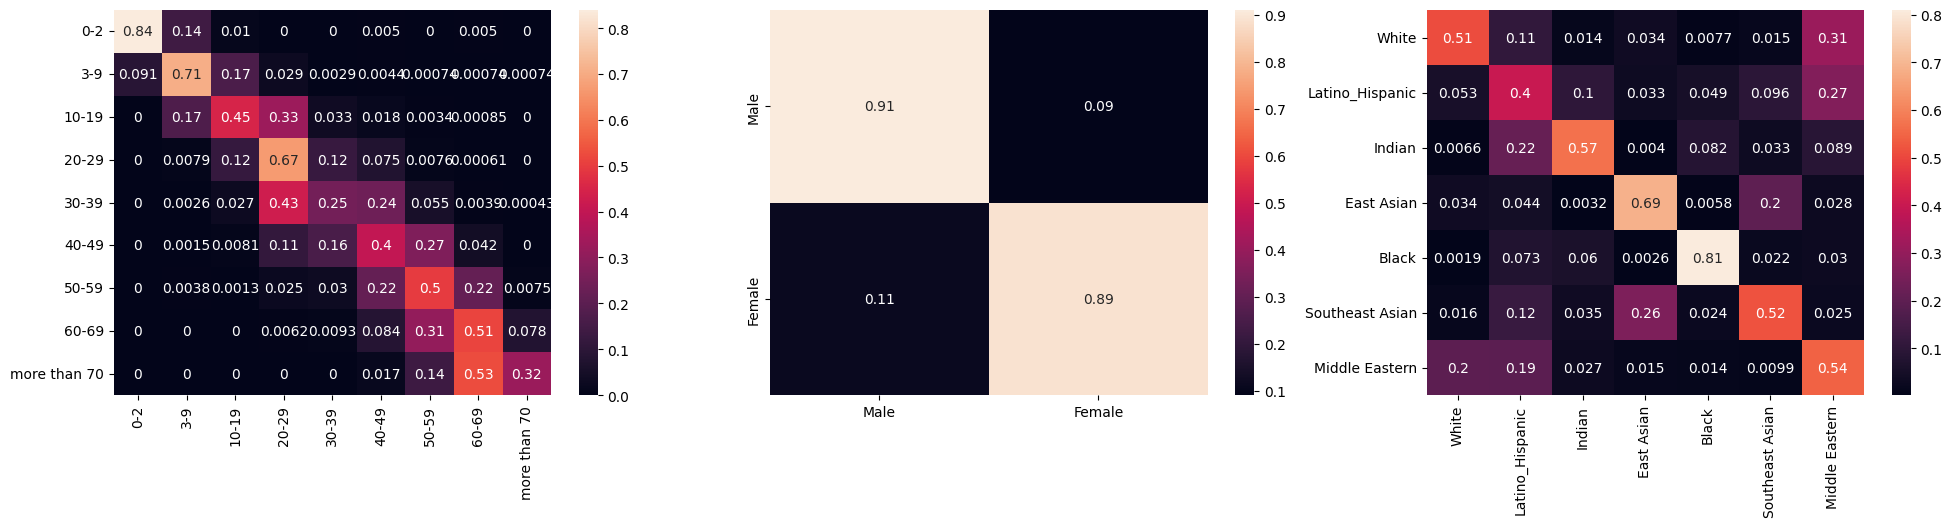

In [15]:
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}

ages, genders, races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [16]:
metrics.calc_measures(model, val_loader, device)

100%|██████████| 22/22 [00:06<00:00,  3.46it/s]


accuracy  precision    recall        f1
age     0.508855   0.493169  0.515885  0.492138
gender  0.899671   0.899534  0.899070  0.899282
race    0.573946   0.593161  0.576566  0.577226

In [58]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

true_cat = 'Latino_Hispanic'
pred_cat = 'Middle Eastern'
mism_imgs = get_mismatched_classes(model, val_loader, true_cat, pred_cat, race_dict, 'race', device)
mism_imgs = [i.cpu() for i in mism_imgs]

100%|██████████| 22/22 [00:05<00:00,  3.84it/s]


In [59]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return self.unnormalize(x)

    def unnormalize(self, x):
        # Assuming x is a PyTorch tensor
        return x * self.std[None, :, None, None] + self.mean[None, :, None, None]

def show(imgs, true_cat, pred_cat):
    if not os.path.exists('../mismatched'):
        os.mkdir('../mismatched')
        
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(tqdm(imgs)):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title(f'True category = {true_cat}; Mismatched one = {pred_cat}')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

# Example Usage:
mean = [0.485, 0.456, 0.406]  # Replace with your actual mean values
std = [0.229, 0.224, 0.225]   # Replace with your actual standard deviation values

# Create an instance of Unnormalize
unnormalize = Unnormalize(mean=mean, std=std)
show([unnormalize(i).squeeze(0) for i in mism_imgs], true_cat, pred_cat)

100%|██████████| 435/435 [00:22<00:00, 19.62it/s]
